In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Load the data

In [223]:
df_raw = pd.read_csv('data/train.csv')

In [224]:
df_raw.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Pre-Processing

In [225]:
# Select the columns to be considered
selected_columns = ['MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape', 'SalePrice']
df_temp = df_raw[selected_columns]

In [226]:
df_temp['Price'] = df_temp.SalePrice/df_temp.LotArea

In [227]:
df_temp.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,SalePrice,Price
0,60,RL,8450,Pave,Reg,208500,24.674556
1,20,RL,9600,Pave,Reg,181500,18.906250
2,60,RL,11250,Pave,IR1,223500,19.866667
3,70,RL,9550,Pave,IR1,140000,14.659686
4,60,RL,14260,Pave,IR1,250000,17.531557


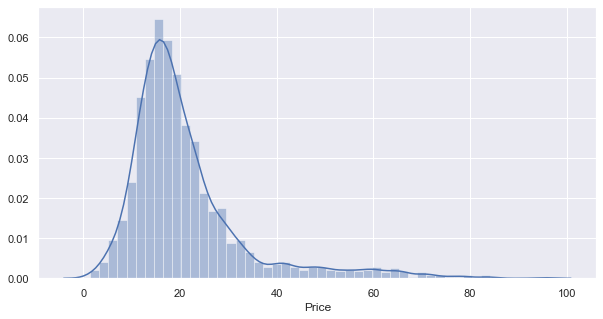

In [228]:
plt.figure(figsize=(10,5))
sns.distplot(df_temp.Price);

In [229]:
# Remove the outliers
q = df_temp.Price.quantile(0.99)
df_temp = df_temp[df_temp.Price<q]

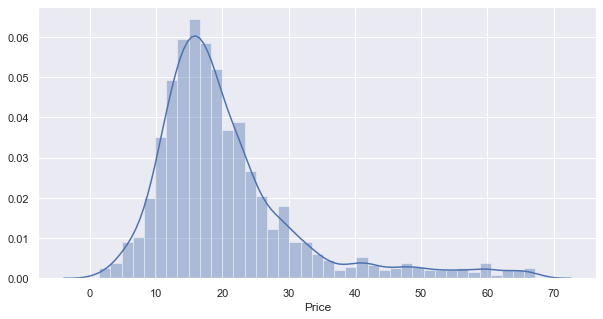

In [230]:
plt.figure(figsize=(10,5))
sns.distplot(df_temp.Price);

In [231]:
df_temp.Street.value_counts()

Pave    1439
Grvl       6
Name: Street, dtype: int64

In [232]:
df_temp.Price.describe()

count    1445.000000
mean       20.495230
std        11.063470
min         1.390441
25%        13.750000
50%        17.789757
75%        23.495019
max        67.271589
Name: Price, dtype: float64

In [233]:
df_temp.isnull().sum()

MSSubClass    0
MSZoning      0
LotArea       0
Street        0
LotShape      0
SalePrice     0
Price         0
dtype: int64

In [234]:
df_group = df_temp.groupby('MSZoning').mean()
df_group

,MSSubClass,LotArea,SalePrice,Price
MSZoning,,,,
C (all),56.000000,9501.300000,74528.000000,8.331825
FV,84.666667,7012.250000,217475.233333,36.030711
RH,80.312500,7380.062500,131558.375000,20.051205
RL,49.155052,11594.669861,190963.640244,19.094403
RM,82.819905,6507.450237,124355.777251,24.309253


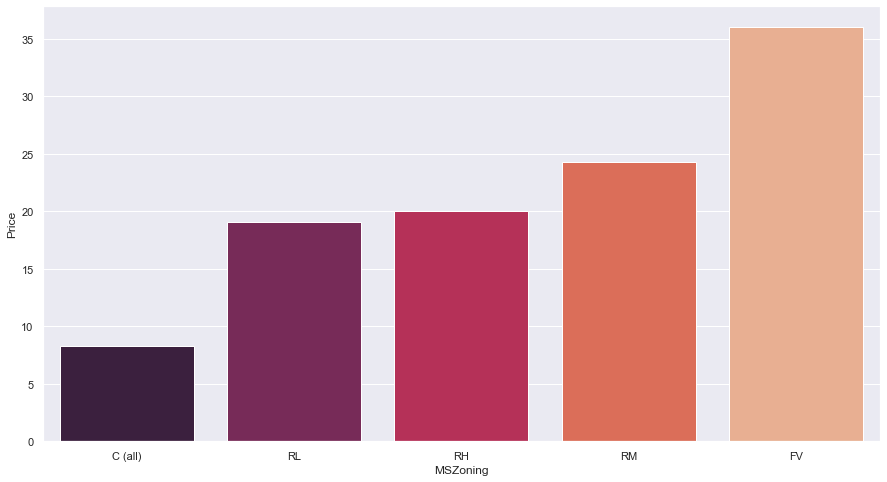

In [240]:
plt.figure(figsize=(15,8))
sns.barplot(df_group.index, df_group.Price, order = df_group.sort_values('Price').index, palette='rocket');

## Create dummy variables for categorical data

In [238]:
df_dummies = [pd.get_dummies(df_temp.MSSubClass, prefix = 'Class', prefix_sep = ':'),
              pd.get_dummies(df_temp.MSZoning, prefix = 'Zone', prefix_sep = ':'),
              pd.get_dummies(df_temp.Street, prefix = 'Street', prefix_sep = ':'),
              pd.get_dummies(df_temp.LotShape, prefix = 'Shape', prefix_sep = ':')]

df_dummies = pd.concat(df_dummies, axis=1)

In [239]:
df = pd.concat([df_temp, df_dummies], axis = 1)
df.drop(['MSSubClass','MSZoning','Street','LotShape','LotArea','SalePrice'], axis = 1, inplace = True)
df.head()

,Price,Class:20,Class:30,Class:40,Class:45,Class:50,Class:60,Class:70,Class:75,Class:80,...,Zone:FV,Zone:RH,Zone:RL,Zone:RM,Street:Grvl,Street:Pave,Shape:IR1,Shape:IR2,Shape:IR3,Shape:Reg
0,24.674556,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,1
1,18.906250,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
2,19.866667,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,1,0,0,0
3,14.659686,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,1,0,0,0
4,17.531557,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,1,0,0,0


## Split the data

In [269]:
x_train, x_valid, y_train,  y_valid = train_test_split(df.drop('Price', axis = 1), df.Price, test_size = 0.2, random_state = 42)
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((1156, 26), (1156,), (289, 26), (289,))

# Build and Train the Model

In [270]:
# Create function to evaluate our model
def show_scores(model):
    train_preds = model.predict(x_train)
    val_preds = model.predict(x_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": np.sqrt(mean_absolute_error(y_train, train_preds)),
              "Valid RMSLE": np.sqrt(mean_absolute_error(y_valid, val_preds)),
              "Training R^2": model.score(x_train, y_train),
              "Valid R^2": model.score(x_valid, y_valid)}
    return scores

In [271]:
model = RandomForestRegressor(n_jobs = -1)

In [272]:
model.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [273]:
show_scores(model)

{'Training MAE': 4.551379072673341,
 'Valid MAE': 5.356087274018235,
 'Training RMSLE': 2.133396135900068,
 'Valid RMSLE': 2.3143222061800803,
 'Training R^2': 0.6739076341293184,
 'Valid R^2': 0.5296467170110528}